In [1]:
import pandas as pd
import numpy as np
import warnings
import collections
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm #needs IT permission
from pandas.plotting import register_matplotlib_converters
from datetime import date, datetime, time, timedelta
from math import sqrt
from sklearn.model_selection import train_test_split
import pyodbc
import pickle
import sidetable as stb
from pandas.tseries.offsets import MonthEnd


register_matplotlib_converters()


import seaborn as sns
import datetime
import math
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [2]:
df = pd.read_csv('TorontoMeasureData.csv')

In [3]:
df.head()

,Measure Name,Year,Period,Value
0,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Jan,3778.0
1,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Feb,3234.0
2,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Mar,3789.0
3,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Apr,3821.0
4,Crime Total Number of Incidents (in 7 Crime Ca...,2007,May,3975.0


In [5]:
df['Year'].max()

2020

In [8]:
df.loc[df['Measure Name']]

,Measure Name,Year,Period,Value
0,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Jan,3778.0000
1,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Feb,3234.0000
2,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Mar,3789.0000
3,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Apr,3821.0000
4,Crime Total Number of Incidents (in 7 Crime Ca...,2007,May,3975.0000
5,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Jun,4019.0000
6,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Jul,3864.0000
7,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Aug,4079.0000
8,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Sep,3994.0000
9,Crime Total Number of Incidents (in 7 Crime Ca...,2007,Oct,3911.0000


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Measure Name  320 non-null    object 
 1   Year          320 non-null    int64  
 2   Period        320 non-null    object 
 3   Value         320 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


In [48]:
df.stb.freq(['Measure Name'])


,Measure Name,Count,Percent,Cumulative Count,Cumulative Percent
0,Unemployment Rate (Toronto Residents),161,0.503125,161,0.503125
1,Crime Total Number of Incidents (in 7 Crime Ca...,159,0.496875,320,1.000000


In [49]:
mapper = {v: k for k,v in enumerate(calendar.month_abbr)}


In [50]:
df['Month'] = df['Period'].map(mapper)

In [52]:
df['day'] =1

In [53]:
df['YearMonth'] = pd.to_datetime(df[['Year','Month','day']])

In [55]:
df.groupby(['YearMonth','Measure Name'],as_index=False).Value

,YearMonth,Measure Name,Value
0,2007-01-01,Crime Total Number of Incidents (in 7 Crime Ca...,3778.0000
1,2007-01-01,Unemployment Rate (Toronto Residents),0.0768
2,2007-02-01,Crime Total Number of Incidents (in 7 Crime Ca...,3234.0000
3,2007-02-01,Unemployment Rate (Toronto Residents),0.0751
4,2007-03-01,Crime Total Number of Incidents (in 7 Crime Ca...,3789.0000
5,2007-03-01,Unemployment Rate (Toronto Residents),0.0801
6,2007-04-01,Crime Total Number of Incidents (in 7 Crime Ca...,3821.0000
7,2007-04-01,Unemployment Rate (Toronto Residents),0.0815
8,2007-05-01,Crime Total Number of Incidents (in 7 Crime Ca...,3975.0000
9,2007-05-01,Unemployment Rate (Toronto Residents),0.0805


In [60]:
df_1 = df.pivot_table(values='Value', index=df.YearMonth, columns='Measure Name', aggfunc='first')

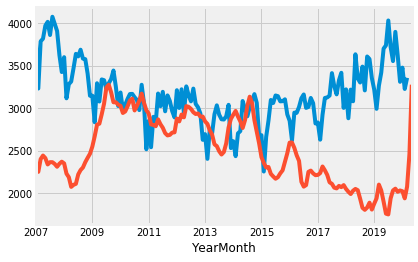

In [73]:
df_1['Crime Total Number of Incidents (in 7 Crime Categories)'].plot()
(df_1['Unemployment Rate (Toronto Residents)']*30000).plot()


In [75]:
df_1.corr()

Measure Name,Crime Total Number of Incidents (in 7 Crime Categories),Unemployment Rate (Toronto Residents)
Measure Name,,
Crime Total Number of Incidents (in 7 Crime Categories),1.000000,-0.398665
Unemployment Rate (Toronto Residents),-0.398665,1.000000
